In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm.auto import tqdm
from timm.scheduler import CosineLRScheduler
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import time
from sklearn.metrics import average_precision_score
from timm.scheduler import CosineLRScheduler
plt.style.use("ggplot")
import json
from pyarrow.parquet import ParquetFile
import pyarrow as pa
import ctypes
import gc
import os
import torch.jit as jit
import torch.autograd as autograd
import random 

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/lstm-datasets-multivariate-univariate/pollution_test_data1.csv
/kaggle/input/lstm-datasets-multivariate-univariate/LSTM-Multivariate_pollution.csv


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
use_cuda = torch.cuda.is_available()
device

'cuda'

In [4]:
SEED = 1
os.environ["PL_GLOBAL_SEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [5]:
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [6]:
df_train = pd.read_csv("/kaggle/input/lstm-datasets-multivariate-univariate/LSTM-Multivariate_pollution.csv")
df_train

date  pollution  dew  temp   press wnd_dir  wnd_spd  \
0      2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79   
1      2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68   
2      2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57   
3      2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36   
4      2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25   
...                    ...        ...  ...   ...     ...     ...      ...   
43795  2014-12-31 19:00:00        8.0  -23  -2.0  1034.0      NW   231.97   
43796  2014-12-31 20:00:00       10.0  -22  -3.0  1034.0      NW   237.78   
43797  2014-12-31 21:00:00       10.0  -22  -3.0  1034.0      NW   242.70   
43798  2014-12-31 22:00:00        8.0  -22  -4.0  1034.0      NW   246.72   
43799  2014-12-31 23:00:00       12.0  -21  -3.0  1034.0      NW   249.85   

       snow  rain  
0         0     0  
1         0     0  
2         0     0  
3         1     0  
4         2     0  
...     ...   ...  
43795     0     0  
43796     0     0  
43797     0     0  
43798     0     0  
43799     0     0  

[43800 rows x 9 columns]

In [7]:
df_train = df_train.drop(columns = ["date"])

In [8]:
df_test = pd.read_csv("/kaggle/input/lstm-datasets-multivariate-univariate/pollution_test_data1.csv")
df_test

dew  temp  press wnd_dir  wnd_spd  snow  rain  pollution
0    -16     4   1027      SE     3.58     0     0        128
1    -17     5   1027      SE     7.60     0     0         77
2    -16     4   1027      SE     9.39     0     0         65
3    -16     1   1028      cv     0.89     0     0         79
4    -14     0   1028      NE     1.79     0     0         93
..   ...   ...    ...     ...      ...   ...   ...        ...
341  -23    -2   1034      NW   231.97     0     0          8
342  -22    -3   1034      NW   237.78     0     0         10
343  -22    -3   1034      NW   242.70     0     0         10
344  -22    -4   1034      NW   246.72     0     0          8
345  -21    -3   1034      NW   249.85     0     0         12

[346 rows x 8 columns]

In [9]:
def cleaning(data: pd.DataFrame)->pd.DataFrame:
    print("before cleaning data")
    print(data.isna().sum())
    print("len of data is: ",len(data))
    
    print("after cleaning data")
    data.dropna()
    print(data.isna().sum())
    print("len of data is: ",len(data))
    return data
df_train = cleaning(df_train)

before cleaning data
pollution    0
dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
dtype: int64
len of data is:  43800
after cleaning data
pollution    0
dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
dtype: int64
len of data is:  43800


In [10]:
def view_data(data:pd.DataFrame)->None:
    #set subploannotationst parameters
    n_col = 2
    columns =  data.columns.tolist()
    
    #Create a subplot for each variable
    fig = make_subplots(rows =len(columns)//2,cols = n_col, subplot_titles = columns)
    colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880']
    
    #counter for plot figure
    counts = 0
    
    #plot figures
    for col_color in zip (columns, colors):
        row = (counts >> 1) +1
        col = (counts & 1) +1
        fig.add_trace(go.Histogram(x=data[col_color[0]], nbinsx=20, marker_color=col_color[1]), row=row, col=col)
        
        #set x and y title
        fig.update_xaxes(title_text = 'value', row = row, col = col)
        fig.update_yaxes(title_text = 'Frequency', row = row, col = col)
        
        counts +=1
    #update layout and set set subplot title size
    fig.update_layout(height=1000, width=1200, title_text='Distribution of Variables', showlegend=False)
    fig.update_annotations(font_size=16)    
    
    fig.show()
    return
    
view_data(df_train)

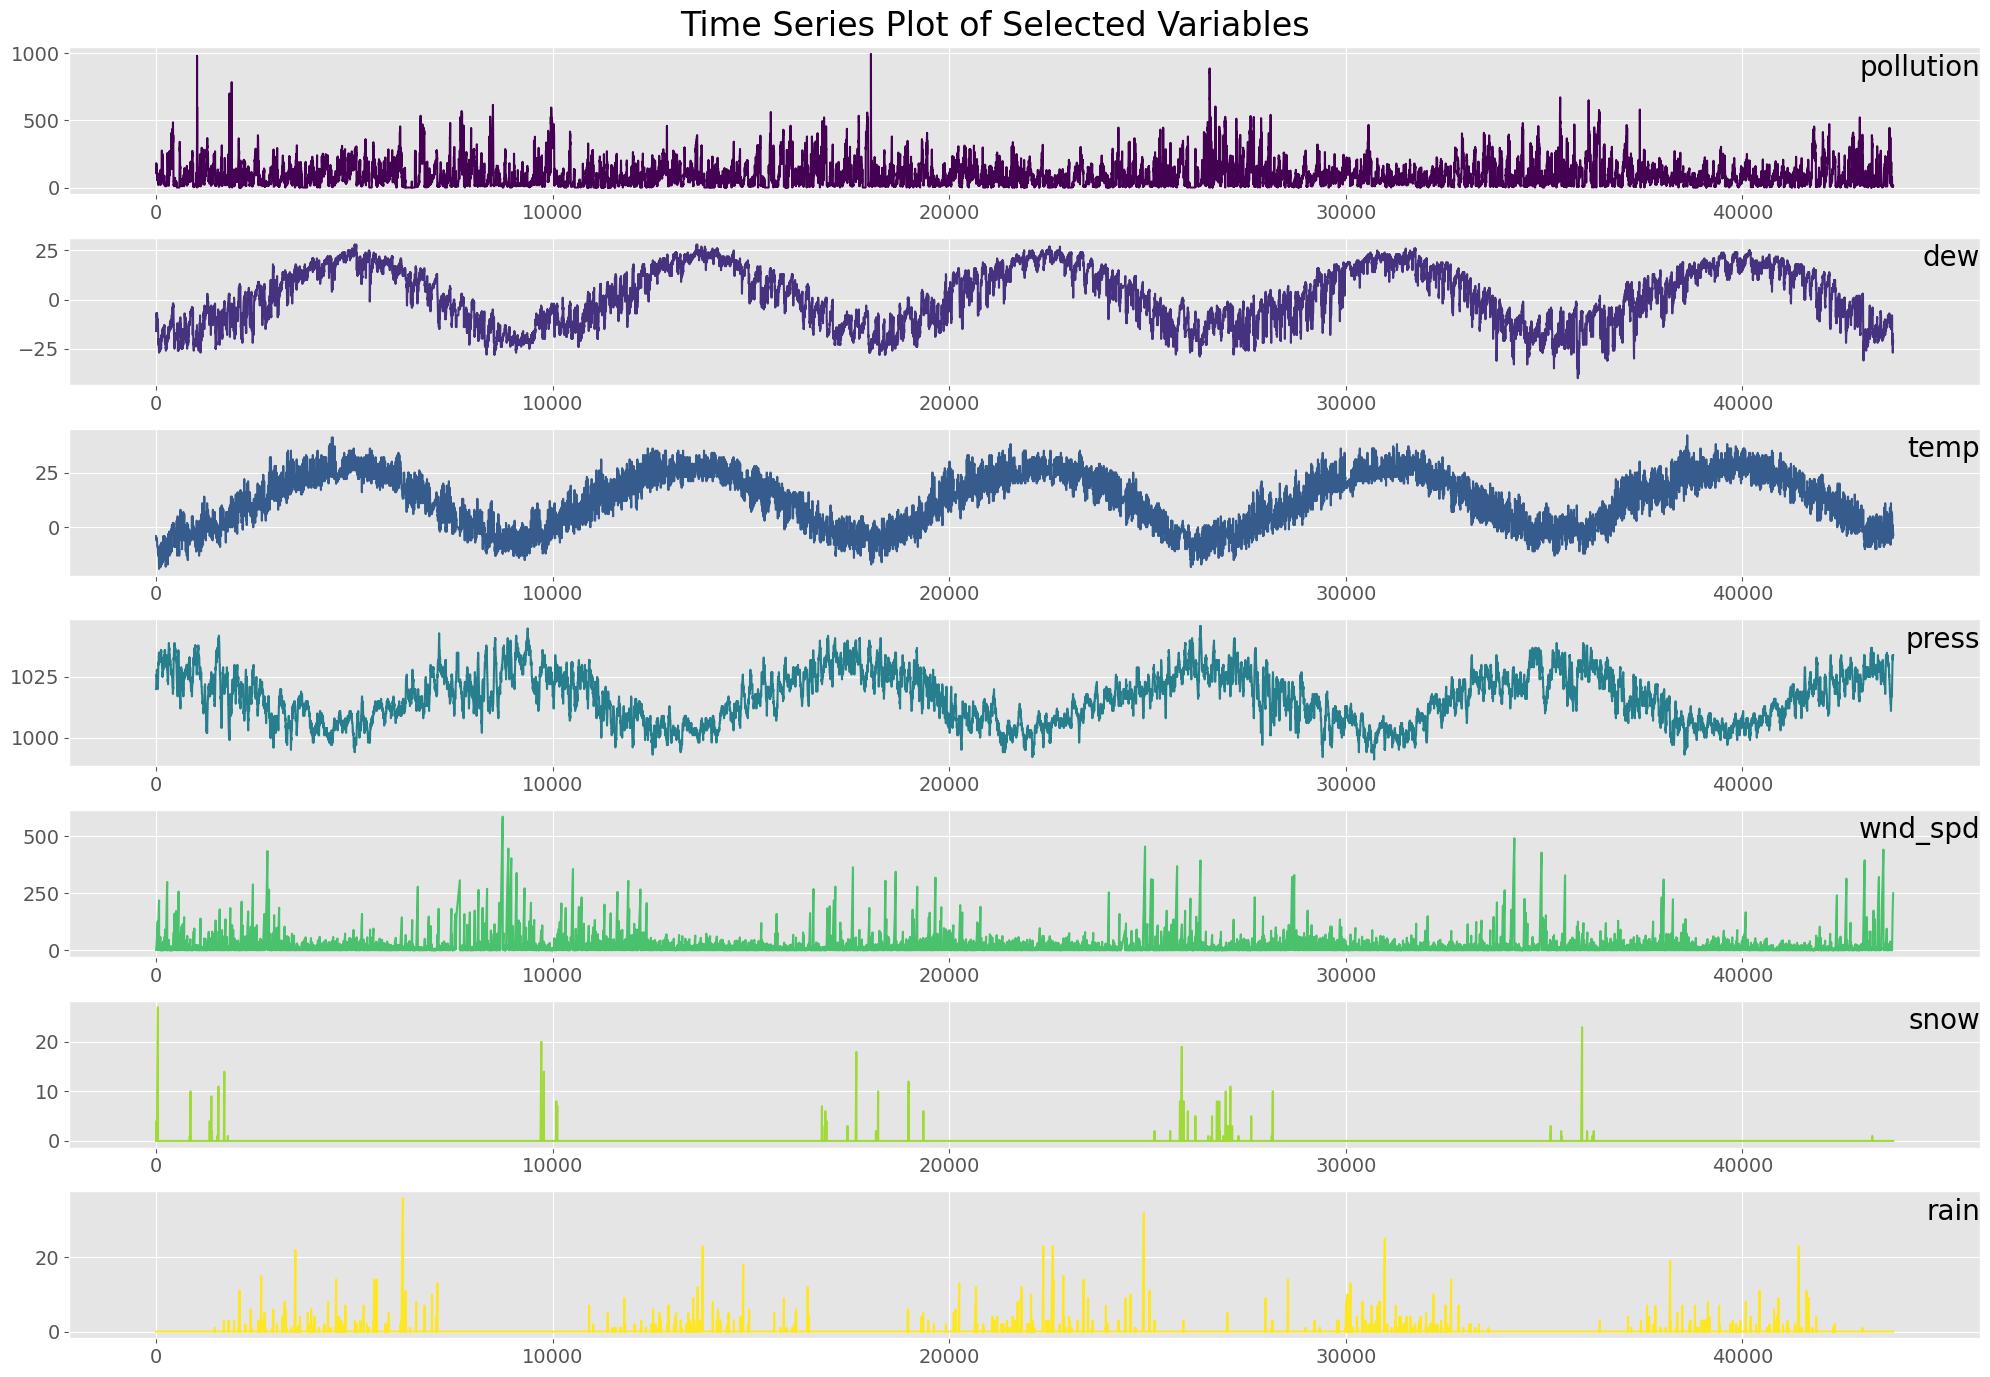

In [11]:
#plot time series figures

def view_timeseries(data:pd.DataFrame)->None:
    groups = [0,1,2,3,5,6,7]
    values = data.values
    fig, axes = plt.subplots(len(groups), 1, figsize=(20,14), facecolor = "white")
    for group, ax in zip(groups, axes):
        ax.plot(values[:, group], color=cm.viridis(group/len(groups)))
        ax.set_title(data.columns[group], y=0.75, loc='right', fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.grid(True)
        
    plt.suptitle('Time Series Plot of Selected Variables', fontsize=24)
    plt.tight_layout()
    plt.show()
    
    return

view_timeseries(df_train)

In [12]:
df_train = df_train.drop(columns = ["snow"])
df_test = df_test.drop(columns = ["snow"])

In [13]:
#one hot encoding
from sklearn.preprocessing import OneHotEncoder
catogorical_columns = df_train.select_dtypes(include = ['object']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False)
encoder.fit(df_train[catogorical_columns])
train_encoded = encoder.transform(df_train[catogorical_columns])
test_encoded = encoder.transform(df_test[catogorical_columns])

train_encoded_df = pd.DataFrame(train_encoded, columns = encoder.get_feature_names_out(catogorical_columns))
test_encoded_df = pd.DataFrame(test_encoded, columns = encoder.get_feature_names_out(catogorical_columns))

df_train = pd.concat([df_train, train_encoded_df], axis = 1)
df_test = pd.concat([df_test, test_encoded_df], axis = 1)

df_train = df_train.drop(catogorical_columns, axis = 1)
df_test = df_test.drop(catogorical_columns, axis = 1)

df_test

dew  temp  press  wnd_spd  rain  pollution  wnd_dir_NE  wnd_dir_NW  \
0    -16     4   1027     3.58     0        128         0.0         0.0   
1    -17     5   1027     7.60     0         77         0.0         0.0   
2    -16     4   1027     9.39     0         65         0.0         0.0   
3    -16     1   1028     0.89     0         79         0.0         0.0   
4    -14     0   1028     1.79     0         93         1.0         0.0   
..   ...   ...    ...      ...   ...        ...         ...         ...   
341  -23    -2   1034   231.97     0          8         0.0         1.0   
342  -22    -3   1034   237.78     0         10         0.0         1.0   
343  -22    -3   1034   242.70     0         10         0.0         1.0   
344  -22    -4   1034   246.72     0          8         0.0         1.0   
345  -21    -3   1034   249.85     0         12         0.0         1.0   

     wnd_dir_SE  wnd_dir_cv  
0           1.0         0.0  
1           1.0         0.0  
2           1.0         0.0  
3           0.0         1.0  
4           0.0         0.0  
..          ...         ...  
341         0.0         0.0  
342         0.0         0.0  
343         0.0         0.0  
344         0.0         0.0  
345         0.0         0.0  

[346 rows x 10 columns]

In [14]:
# # df_train_scaled = df_train.copy()
# # df_test_scaled = df_test.copy()

# # Define the mapping dictionary
# mapping = {'NE': 0, 'SE': 1, 'NW': 2, 'cv': 3}

# # Replace the string values with numerical values
# df_train['wnd_dir'] = df_train['wnd_dir'].map(mapping)
# df_test['wnd_dir'] = df_test['wnd_dir'].map(mapping)

# # df_train_scaled['date'] = pd.to_datetime(df_train_scaled['date'])
# # Resetting the index
# # df_train_scaled.set_index('date', inplace=True)
# df_train.head()

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

cols = [i for i in range(8)]
columns = df_train.columns[cols].tolist()

df_train[columns] = scaler.fit_transform(df_train[columns])
df_test[columns] = scaler.transform(df_test[columns])

df_train

pollution       dew      temp     press   wnd_spd  rain  wnd_dir_NE  \
0       0.129779  0.352941  0.245902  0.527273  0.002290   0.0         0.0   
1       0.148893  0.367647  0.245902  0.527273  0.003811   0.0         0.0   
2       0.159960  0.426471  0.229508  0.545455  0.005332   0.0         0.0   
3       0.182093  0.485294  0.229508  0.563636  0.008391   0.0         0.0   
4       0.138833  0.485294  0.229508  0.563636  0.009912   0.0         0.0   
...          ...       ...       ...       ...       ...   ...         ...   
43795   0.008048  0.250000  0.278689  0.781818  0.395659   0.0         0.0   
43796   0.010060  0.264706  0.262295  0.781818  0.405588   0.0         0.0   
43797   0.010060  0.264706  0.262295  0.781818  0.413996   0.0         0.0   
43798   0.008048  0.264706  0.245902  0.781818  0.420866   0.0         0.0   
43799   0.012072  0.279412  0.262295  0.781818  0.426216   0.0         0.0   

       wnd_dir_NW  wnd_dir_SE  wnd_dir_cv  
0             0.0         1.0         0.0  
1             0.0         1.0         0.0  
2             0.0         1.0         0.0  
3             0.0         1.0         0.0  
4             0.0         1.0         0.0  
...           ...         ...         ...  
43795         1.0         0.0         0.0  
43796         1.0         0.0         0.0  
43797         1.0         0.0         0.0  
43798         1.0         0.0         0.0  
43799         1.0         0.0         0.0  

[43800 rows x 10 columns]

In [16]:
train_size = int(len(df_train) * 0.9)
num_epochs = 150
steps = train_size*num_epochs
warmup_steps = int(steps*0.2)
train= df_train.iloc[:train_size, :]
val = df_train.iloc[train_size:, :]
train

pollution       dew      temp     press   wnd_spd      rain  \
0       0.129779  0.352941  0.245902  0.527273  0.002290  0.000000   
1       0.148893  0.367647  0.245902  0.527273  0.003811  0.000000   
2       0.159960  0.426471  0.229508  0.545455  0.005332  0.000000   
3       0.182093  0.485294  0.229508  0.563636  0.008391  0.000000   
4       0.138833  0.485294  0.229508  0.563636  0.009912  0.000000   
...          ...       ...       ...       ...       ...       ...   
39415   0.058350  0.882353  0.655738  0.236364  0.003811  0.000000   
39416   0.057344  0.882353  0.672131  0.236364  0.000752  0.027778   
39417   0.052314  0.897059  0.672131  0.236364  0.000752  0.055556   
39418   0.033199  0.897059  0.688525  0.236364  0.000752  0.000000   
39419   0.050302  0.897059  0.704918  0.236364  0.002290  0.000000   

       wnd_dir_NE  wnd_dir_NW  wnd_dir_SE  wnd_dir_cv  
0             0.0         0.0         1.0         0.0  
1             0.0         0.0         1.0         0.0  
2             0.0         0.0         1.0         0.0  
3             0.0         0.0         1.0         0.0  
4             0.0         0.0         1.0         0.0  
...           ...         ...         ...         ...  
39415         0.0         0.0         1.0         0.0  
39416         0.0         0.0         0.0         1.0  
39417         0.0         0.0         1.0         0.0  
39418         0.0         0.0         0.0         1.0  
39419         0.0         0.0         1.0         0.0  

[39420 rows x 10 columns]

In [17]:
window_size = 24*7

# TrainSet
X_sequences = []
y_values = []

n_past = 24*7
n_future = 1

for i in range(n_past, len(train) - n_future+1):
    X_seq = train.iloc[i - n_past:i].drop(columns=["pollution"]).values
    y_val = train.iloc[i + n_future - 1:i + n_future].pollution
    X_sequences.append(X_seq)
    y_values.append(y_val)

X_train = np.array(X_sequences)
y_train = np.array(y_values)

# ValidSet
X_sequences = []
y_values = []

for i in range(n_past, len(val) - n_future+1):
    X_seq = val.iloc[i - n_past:i].drop(columns=["pollution"]).values
    y_val = val.iloc[i + n_future - 1:i + n_future].pollution
    X_sequences.append(X_seq)
    y_values.append(y_val)

X_valid = np.array(X_sequences)
y_valid = np.array(y_values)

# TestSet
X_sequences = []
y_values = []
for i in range(n_past, len(df_test) - n_future+1):
    X_seq = df_test.iloc[ i- n_past:i].drop(columns=["pollution"]).values
    Y_val = df_test.iloc[i + n_future - 1:i + n_future]['pollution']
    X_sequences.append(X_seq)
    y_values.append(Y_val)

X_test = np.array(X_sequences)
y_test = np.array(y_values)

print('train_data'.center(50, '-'))
print(X_train.shape)
print(y_train.shape)
print('test_data'.center(50, '-'))
print(X_test.shape)
print(y_test.shape)

--------------------train_data--------------------
(39252, 168, 9)
(39252, 1)
--------------------test_data---------------------
(178, 168, 9)
(178, 1)


In [18]:
# # Calculating mean and standard deviation for standardization of features in the training set
# X_train_mean = X_train.mean()
# X_train_std = X_train.std()

# # Standardizing features in the training and validation sets based on the training set statistics
# X_train = (X_train - X_train_mean) / X_train_std
# X_valid = (X_valid - X_train_mean) / X_train_std

# # Calculating mean and standard deviation for standardization of target values in the training set
# y_train_mean = y_train.mean()
# y_train_std = y_train.std()

# # Standardizing target values in the training and validation sets based on the training set statistics
# y_train = (y_train - y_train_mean) / y_train_std
# y_valid = (y_valid - y_train_mean) / y_train_std
# X_test = (X_test - X_train_mean) / X_train_std
# y_test = (y_test - y_train_mean) / y_train_std

In [19]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_valid = torch.from_numpy(X_valid.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32).reshape(-1,1))
y_valid = torch.from_numpy(y_valid.astype(np.float32).reshape(-1,1))
y_test = torch.from_numpy(y_test.astype(np.float32).reshape(-1,1))

In [20]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)

In [21]:
class ResidualBiGRU(nn.Module):
    def __init__(self, hidden_size, n_layers=1, bidir=True):
        super(ResidualBiGRU, self).__init__()

        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.gru = nn.GRU(
            hidden_size,
            hidden_size,
            n_layers,
            batch_first=True,
            bidirectional=bidir,
        )
        dir_factor = 2 if bidir else 1
        self.fc1 = nn.Linear(
            hidden_size * dir_factor, hidden_size * dir_factor * 2
        )
        self.ln1 = nn.LayerNorm(hidden_size * dir_factor * 2)
        self.fc2 = nn.Linear(hidden_size * dir_factor * 2, hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)

    def forward(self, x, h=None):
        res, new_h = self.gru(x, h)
        # res.shape = (batch_size, sequence_size, 2*hidden_size)

        res = self.fc1(res)
        res = self.ln1(res)
        res = nn.functional.relu(res)

        res = self.fc2(res)
        res = self.ln2(res)
        res = nn.functional.relu(res)

        # skip connection
        res = res + x

        return res, new_h

class MultiResidualBiGRU(nn.Module):
    def __init__(self, input_size, hidden_size, out_size, n_layers, bidir=True):
        super(MultiResidualBiGRU, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.out_size = out_size
        self.n_layers = n_layers

        self.fc_in = nn.Linear(input_size, hidden_size)
        self.ln = nn.LayerNorm(hidden_size)
        self.res_bigrus = nn.ModuleList(
            [
                ResidualBiGRU(hidden_size, n_layers=1, bidir=bidir)
                for _ in range(n_layers)
            ]
        )
        self.fc_out = nn.Linear(hidden_size, out_size)

    def forward(self, x, h=None):
        # if we are at the beginning of a sequence (no hidden state)
        if h is None:
            # (re)initialize the hidden state
            h = [None for _ in range(self.n_layers)]

        x = self.fc_in(x)
        x = self.ln(x)
        x = nn.functional.relu(x)

        new_h = []
        for i, res_bigru in enumerate(self.res_bigrus):
            x, new_hi = res_bigru(x, h[i])
            new_h.append(new_hi)

        x = self.fc_out(x[:, -1, :])
#         x = F.normalize(x,dim=0)
        return x, new_h  # log probabilities + hidden states

In [22]:
from timm.scheduler import CosineLRScheduler


model = MultiResidualBiGRU(input_size=9,hidden_size=16,out_size=1,n_layers=3).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,weight_decay = 0)


steps = train_size*num_epochs
scheduler = CosineLRScheduler(optimizer,t_initial= steps,warmup_t=warmup_steps, warmup_lr_init=1e-5,lr_min=2e-8,)
# scheduler  = torch.optim.lr_scheduler.StepLR(optimizer, 5, 0.5, last_epoch=-1, verbose=False,)
criterion = nn.MSELoss()

print(model)

MultiResidualBiGRU(
  (fc_in): Linear(in_features=9, out_features=16, bias=True)
  (ln): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  (res_bigrus): ModuleList(
    (0-2): 3 x ResidualBiGRU(
      (gru): GRU(16, 16, batch_first=True, bidirectional=True)
      (fc1): Linear(in_features=32, out_features=64, bias=True)
      (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (fc2): Linear(in_features=64, out_features=16, bias=True)
      (ln2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    )
  )
  (fc_out): Linear(in_features=16, out_features=1, bias=True)
)


In [23]:
from torch.utils.data import TensorDataset, DataLoader
batch_size = 8

train_set = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_set,
                          batch_size=batch_size,
                          shuffle=True,
                          drop_last=True,
                          )

val_set = TensorDataset(X_valid, y_valid)
val_loader = DataLoader(val_set,
                          batch_size=batch_size,
                          shuffle=True,
                          drop_last=True,
                          )
test_set = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_set,
                          batch_size=1,
                          shuffle=True,
                          drop_last=True,
                          )

In [24]:
# seed = 3407
# torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)

In [25]:
import copy
model_path = '/kaggle/working/'
history = {
    "train_loss": [],
    "valid_loss": [],
    "valid_mAP": [],
    "lr": [],
}
best_valid_loss = np.inf
best_model_wts = copy.deepcopy(model.state_dict())

In [26]:
def plot_history(history, model_path=".", show=True):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure()
    plt.plot(epochs, history["train_loss"], label="Training Loss")
    plt.plot(epochs, history["valid_loss"], label="Validation Loss")
    plt.title("Loss evolution")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(os.path.join(model_path, "loss_evo.png"))
    if show:
        plt.show()
    plt.close()

#     plt.figure()
#     plt.plot(epochs, history["valid_mAP"])
#     plt.title("Validation mAP evolution")
#     plt.xlabel("Epochs")
#     plt.ylabel("mAP")
#     plt.savefig(os.path.join(model_path, "mAP_evo.png"))
#     if show:
#         plt.show()
#     plt.close()

#     plt.figure()
#     plt.plot(epochs, history["lr"])
#     plt.title("Learning Rate evolution")
#     plt.xlabel("Epochs")
#     plt.ylabel("LR")
#     plt.savefig(os.path.join(model_path, "lr_evo.png"))
#     if show:
#         plt.show()
#     plt.close()

train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 0, train_avg_loss: 0.04915828844074042


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 0, val_avg_loss: 0.007245297319726742


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 1, train_avg_loss: 0.006239467980036627


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 1, val_avg_loss: 0.005167892509929751


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 2, train_avg_loss: 0.0054393064157914955


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 2, val_avg_loss: 0.005302698823411775


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 3, train_avg_loss: 0.004895682738168533


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 3, val_avg_loss: 0.0037090655621747617


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 4, train_avg_loss: 0.004659742272324521


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 4, val_avg_loss: 0.004251721336332791


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 5, train_avg_loss: 0.0044311687866611035


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 5, val_avg_loss: 0.005170394450150777


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 6, train_avg_loss: 0.004259320565944667


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 6, val_avg_loss: 0.004175941830770088


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 7, train_avg_loss: 0.004050622580596834


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 7, val_avg_loss: 0.00461242629258611


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 8, train_avg_loss: 0.003783983755696343


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 8, val_avg_loss: 0.0038755744605101297


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 9, train_avg_loss: 0.003575374843240065


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 9, val_avg_loss: 0.003527719264220581


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 10, train_avg_loss: 0.0034627050971229464


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 10, val_avg_loss: 0.003551441695503076


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 11, train_avg_loss: 0.0032743738196708105


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 11, val_avg_loss: 0.004428825812470062


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 12, train_avg_loss: 0.00311439201813535


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 12, val_avg_loss: 0.003855865456680891


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 13, train_avg_loss: 0.0030268531317631116


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 13, val_avg_loss: 0.003825615163736033


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 14, train_avg_loss: 0.002899073023298017


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 14, val_avg_loss: 0.005218871525821219


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 15, train_avg_loss: 0.00273776620539847


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 15, val_avg_loss: 0.004049356079778984


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 16, train_avg_loss: 0.0026834154410152575


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 16, val_avg_loss: 0.004826426071698243


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 17, train_avg_loss: 0.002544345525312219


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 17, val_avg_loss: 0.003723049160293808


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 18, train_avg_loss: 0.0024422483518132376


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 18, val_avg_loss: 0.005427706187195676


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 19, train_avg_loss: 0.0023438268992887314


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 19, val_avg_loss: 0.00356218664674365


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 20, train_avg_loss: 0.0022736191692370616


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 20, val_avg_loss: 0.003714413496204422


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 21, train_avg_loss: 0.0021811247124613508


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 21, val_avg_loss: 0.004690137734400293


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 22, train_avg_loss: 0.0021439250825597586


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 22, val_avg_loss: 0.0036835053845126354


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 23, train_avg_loss: 0.0020934029868906667


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 23, val_avg_loss: 0.004408258436926722


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 24, train_avg_loss: 0.0019800687852784423


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 24, val_avg_loss: 0.003878752783980192


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 25, train_avg_loss: 0.0019572385378430843


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 25, val_avg_loss: 0.0043662171956384555


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 26, train_avg_loss: 0.0019145088587957158


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 26, val_avg_loss: 0.003287444864652038


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 27, train_avg_loss: 0.0018504005982702678


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 27, val_avg_loss: 0.003512366677344154


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 28, train_avg_loss: 0.0018278804312103973


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 28, val_avg_loss: 0.00336017567790981


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 29, train_avg_loss: 0.0017770015286612479


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 29, val_avg_loss: 0.0033275441548864743


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 30, train_avg_loss: 0.0016356195641439727


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 30, val_avg_loss: 0.004525544648524595


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 31, train_avg_loss: 0.0016187086850596233


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 31, val_avg_loss: 0.003621219252231761


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 32, train_avg_loss: 0.0015670612557842417


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 32, val_avg_loss: 0.0030821551752890667


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 33, train_avg_loss: 0.0015083486696657136


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 33, val_avg_loss: 0.004838001726586071


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 34, train_avg_loss: 0.0014373690560915454


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 34, val_avg_loss: 0.003832053340782904


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 35, train_avg_loss: 0.0014192742980556961


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 35, val_avg_loss: 0.003680975794850383


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 36, train_avg_loss: 0.0013562393281267417


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 36, val_avg_loss: 0.003343524729443259


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 37, train_avg_loss: 0.0013185766211863948


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 37, val_avg_loss: 0.004307253638808279


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 38, train_avg_loss: 0.0013032604693275732


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 38, val_avg_loss: 0.0036947416391335656


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 39, train_avg_loss: 0.0012422963605115858


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 39, val_avg_loss: 0.003797628678975803


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 40, train_avg_loss: 0.0012222640095932418


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 40, val_avg_loss: 0.00403628178305086


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 41, train_avg_loss: 0.0012010106558585428


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 41, val_avg_loss: 0.003971773617537497


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 42, train_avg_loss: 0.0011594033243880401


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 42, val_avg_loss: 0.0034975532615847686


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 43, train_avg_loss: 0.0011276535590737013


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 43, val_avg_loss: 0.0034457322358027163


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 44, train_avg_loss: 0.0011089172783014902


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 44, val_avg_loss: 0.0045123797340324975


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 45, train_avg_loss: 0.0010891014903978312


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 45, val_avg_loss: 0.003619820643369084


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 46, train_avg_loss: 0.0010655158397868886


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 46, val_avg_loss: 0.003882096464106744


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 47, train_avg_loss: 0.0010426226811080712


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 47, val_avg_loss: 0.0035204119776608422


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 48, train_avg_loss: 0.0010089655203021064


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 48, val_avg_loss: 0.0038061346939245694


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 49, train_avg_loss: 0.0009948791777437099


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 49, val_avg_loss: 0.004117828787820362


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 50, train_avg_loss: 0.0009759431600752231


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 50, val_avg_loss: 0.004444241222634224


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 51, train_avg_loss: 0.0009490118382926791


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 51, val_avg_loss: 0.003992262590377098


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 52, train_avg_loss: 0.0009391360630014577


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 52, val_avg_loss: 0.004076935010280517


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 53, train_avg_loss: 0.0009129120617465682


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 53, val_avg_loss: 0.004054638084945775


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 54, train_avg_loss: 0.0008974635163716825


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 54, val_avg_loss: 0.004049364138911824


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 55, train_avg_loss: 0.0008633864567096977


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 55, val_avg_loss: 0.0038601944750124417


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 56, train_avg_loss: 0.0008541424096692105


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 56, val_avg_loss: 0.0034610211785914584


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 57, train_avg_loss: 0.0008421867111884702


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 57, val_avg_loss: 0.0035665807907885433


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 58, train_avg_loss: 0.0008270923062405606


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 58, val_avg_loss: 0.004024278761789901


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 59, train_avg_loss: 0.0008048926968354055


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 59, val_avg_loss: 0.00398534174171164


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 60, train_avg_loss: 0.0007849847692629886


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 60, val_avg_loss: 0.003857758261725712


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 61, train_avg_loss: 0.0007759026901796958


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 61, val_avg_loss: 0.0038146271496905947


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 62, train_avg_loss: 0.0007747988559280865


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 62, val_avg_loss: 0.004041691824004582


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 63, train_avg_loss: 0.0007466400548341007


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 63, val_avg_loss: 0.004103385550527703


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 64, train_avg_loss: 0.0007198791107284457


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 64, val_avg_loss: 0.0034934753830695815


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 65, train_avg_loss: 0.0007165256952213233


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 65, val_avg_loss: 0.003917745718118972


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 66, train_avg_loss: 0.0007172728585558446


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 66, val_avg_loss: 0.003992272147928394


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 67, train_avg_loss: 0.000692071821679217


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 67, val_avg_loss: 0.003730756432221257


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 68, train_avg_loss: 0.0006814427819338799


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 68, val_avg_loss: 0.0036596307133615704


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 69, train_avg_loss: 0.0006505677535215708


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 69, val_avg_loss: 0.004323987875763358


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 70, train_avg_loss: 0.0006384514286257686


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 70, val_avg_loss: 0.0036081118790279878


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 71, train_avg_loss: 0.0006227550350492518


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 71, val_avg_loss: 0.003585173611794979


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 72, train_avg_loss: 0.0006388373210151368


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 72, val_avg_loss: 0.0035832006142438415


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 73, train_avg_loss: 0.000617267627686405


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 73, val_avg_loss: 0.0037767753127474113


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 74, train_avg_loss: 0.0005898744171868579


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 74, val_avg_loss: 0.0037201361263511897


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 75, train_avg_loss: 0.0005836279572987111


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 75, val_avg_loss: 0.003662221350313935


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 76, train_avg_loss: 0.0005664496907157177


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 76, val_avg_loss: 0.0038691920419967247


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 77, train_avg_loss: 0.0005877791060125141


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 77, val_avg_loss: 0.003870207062927287


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 78, train_avg_loss: 0.0005538880113625068


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 78, val_avg_loss: 0.003658473407538712


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 79, train_avg_loss: 0.0005413635423632783


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 79, val_avg_loss: 0.003431450273153751


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 80, train_avg_loss: 0.0005315625773314702


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 80, val_avg_loss: 0.0035503767336167204


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 81, train_avg_loss: 0.0005359953926544857


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 81, val_avg_loss: 0.0038277854991871146


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 82, train_avg_loss: 0.00049716641573575


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 82, val_avg_loss: 0.004082753820384201


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 83, train_avg_loss: 0.0005027371653278076


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 83, val_avg_loss: 0.004123711434409629


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 84, train_avg_loss: 0.0004890993934271808


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 84, val_avg_loss: 0.0037948909942975874


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 85, train_avg_loss: 0.00048407158055722283


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 85, val_avg_loss: 0.004126458551052793


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 86, train_avg_loss: 0.00047442116229674466


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 86, val_avg_loss: 0.0039213117723421375


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 87, train_avg_loss: 0.00045872692557171157


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 87, val_avg_loss: 0.0041254266587811075


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 88, train_avg_loss: 0.00045835444551832195


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 88, val_avg_loss: 0.003884660615203964


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 89, train_avg_loss: 0.00044652297526093053


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 89, val_avg_loss: 0.0038930420672661312


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 90, train_avg_loss: 0.0004377191686091655


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 90, val_avg_loss: 0.0041295038923227665


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 91, train_avg_loss: 0.00043200558685976863


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 91, val_avg_loss: 0.004317571924201048


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 92, train_avg_loss: 0.0004206104898789504


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 92, val_avg_loss: 0.003735400076682003


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 93, train_avg_loss: 0.00040985907343329085


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 93, val_avg_loss: 0.003897488642387232


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 94, train_avg_loss: 0.00040902489925824346


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 94, val_avg_loss: 0.004030707606950823


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 95, train_avg_loss: 0.0003959398953025527


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 95, val_avg_loss: 0.003943724841990033


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 96, train_avg_loss: 0.0003890625500005317


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 96, val_avg_loss: 0.004019095662186947


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 97, train_avg_loss: 0.0003825482655136647


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 97, val_avg_loss: 0.004082407586941825


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 98, train_avg_loss: 0.0003783972967174162


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 98, val_avg_loss: 0.003904977946709523


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 99, train_avg_loss: 0.0003693948762027179


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 99, val_avg_loss: 0.0041973186795878185


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 100, train_avg_loss: 0.00036344940743767177


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 100, val_avg_loss: 0.003923143833294022


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 101, train_avg_loss: 0.00035617122911216594


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 101, val_avg_loss: 0.003953777366847764


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 102, train_avg_loss: 0.00034913633573692166


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 102, val_avg_loss: 0.003910824176383969


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 103, train_avg_loss: 0.00034740443685905956


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 103, val_avg_loss: 0.004154741962068712


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 104, train_avg_loss: 0.0003388262046391575


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 104, val_avg_loss: 0.004006894258538813


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 105, train_avg_loss: 0.0003316353001842722


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 105, val_avg_loss: 0.004012326270325496


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 106, train_avg_loss: 0.00032806407933348654


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 106, val_avg_loss: 0.0041070141323940376


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 107, train_avg_loss: 0.00032117174233050054


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 107, val_avg_loss: 0.004007575328161602


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 108, train_avg_loss: 0.0003165701328620918


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 108, val_avg_loss: 0.0042485298751875535


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 109, train_avg_loss: 0.0003083383238147486


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 109, val_avg_loss: 0.00425226912315193


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 110, train_avg_loss: 0.0003063346563049374


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 110, val_avg_loss: 0.0042257503636368154


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 111, train_avg_loss: 0.0002988941962665864


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 111, val_avg_loss: 0.00426288973663178


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 112, train_avg_loss: 0.00029735486076844946


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 112, val_avg_loss: 0.004137576300665055


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 113, train_avg_loss: 0.00028997059534739927


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 113, val_avg_loss: 0.0042568126369076035


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 114, train_avg_loss: 0.00028664968514495367


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 114, val_avg_loss: 0.0042949462393969354


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 115, train_avg_loss: 0.0002826599965527171


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 115, val_avg_loss: 0.004013049118344747


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 116, train_avg_loss: 0.00027728888987921485


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 116, val_avg_loss: 0.00422308509778892


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 117, train_avg_loss: 0.0002740247581039284


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 117, val_avg_loss: 0.004389989550309318


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 118, train_avg_loss: 0.0002699147110404551


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 118, val_avg_loss: 0.0041893472024788474


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 119, train_avg_loss: 0.00026703070337617075


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 119, val_avg_loss: 0.004321831337049501


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 120, train_avg_loss: 0.00026244267740893786


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 120, val_avg_loss: 0.0042719566484303705


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 121, train_avg_loss: 0.00025906611226733027


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 121, val_avg_loss: 0.004358436844967929


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 122, train_avg_loss: 0.0002555000851027236


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 122, val_avg_loss: 0.0042613098968197535


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 123, train_avg_loss: 0.00025116788001133556


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 123, val_avg_loss: 0.00426779783331079


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 124, train_avg_loss: 0.00024988468248476057


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 124, val_avg_loss: 0.00428636135269415


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 125, train_avg_loss: 0.00024716630788661583


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 125, val_avg_loss: 0.004402871633126903


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 126, train_avg_loss: 0.00024393245247789083


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 126, val_avg_loss: 0.004397824747272833


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 127, train_avg_loss: 0.00024123762420473122


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 127, val_avg_loss: 0.004375987955814576


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 128, train_avg_loss: 0.00023865113991486001


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 128, val_avg_loss: 0.004295965531093295


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 129, train_avg_loss: 0.00023646389876608748


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 129, val_avg_loss: 0.00428415208620824


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 130, train_avg_loss: 0.0002344337351580967


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 130, val_avg_loss: 0.004430463175242191


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 131, train_avg_loss: 0.00023189054165923272


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 131, val_avg_loss: 0.0043435365562181135


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 132, train_avg_loss: 0.00023023524882732031


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 132, val_avg_loss: 0.004334691690613902


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 133, train_avg_loss: 0.00022846314145249445


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 133, val_avg_loss: 0.004320677015628033


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 134, train_avg_loss: 0.00022646729691659027


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 134, val_avg_loss: 0.004396229565184309


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 135, train_avg_loss: 0.00022492200079641782


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 135, val_avg_loss: 0.004373892136087452


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 136, train_avg_loss: 0.00022347587308885105


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 136, val_avg_loss: 0.004403381523300633


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 137, train_avg_loss: 0.00022199898144348383


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 137, val_avg_loss: 0.004350126473195036


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 138, train_avg_loss: 0.00022058497409082052


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 138, val_avg_loss: 0.004424631220221957


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 139, train_avg_loss: 0.00021967625308519248


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 139, val_avg_loss: 0.004328295632536406


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 140, train_avg_loss: 0.0002188184183644159


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 140, val_avg_loss: 0.0044216732551523455


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 141, train_avg_loss: 0.00021770173928316888


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 141, val_avg_loss: 0.004420648010339395


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 142, train_avg_loss: 0.00021693073286857377


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 142, val_avg_loss: 0.004398684523800059


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 143, train_avg_loss: 0.00021628592056236083


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 143, val_avg_loss: 0.004397939986178825


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 144, train_avg_loss: 0.00021565462919211542


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 144, val_avg_loss: 0.004395487603390397


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 145, train_avg_loss: 0.0002148843119897689


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 145, val_avg_loss: 0.0043693576721706255


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 146, train_avg_loss: 0.0002146366750810348


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 146, val_avg_loss: 0.004394379245396615


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 147, train_avg_loss: 0.00021428612523013548


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 147, val_avg_loss: 0.004397263737901569


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 148, train_avg_loss: 0.0002140010370556943


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 148, val_avg_loss: 0.004389702837381728


train:   0%|          | 0/4906 [00:00<?, ?batch/s]

Epoch: 149, train_avg_loss: 0.00021386947312912325


Eval:   0%|          | 0/526 [00:00<?, ?batch/s]

Epoch: 149, val_avg_loss: 0.004392647585411514


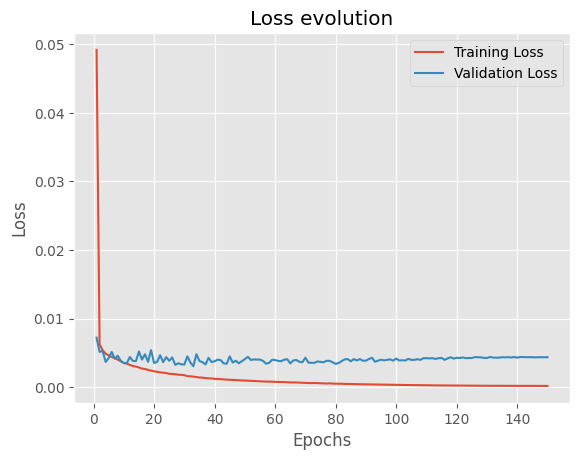

In [27]:
train_losses = []  # To store train losses
test_losses = []   # To store test losses

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    i = 0
    
    for i, (inputs, targets) in enumerate(tqdm(train_loader, desc="train", unit="batch")):
        h = None
        inputs = inputs.reshape(-1, window_size, 9).to(device)
        targets = targets.reshape(-1, 1).to(device)
        outputs,h = model(inputs,h)
        h = [hi.detach() for hi in h]
        optimizer.zero_grad()
        scheduler.step(i+train_size*epoch)
        loss = criterion(outputs, targets)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
#     print(scheduler.get_last_lr())
    train_loss = (train_loss)/len(train_loader)
    print(f'Epoch: {epoch}, train_avg_loss: {train_loss}')
    history["train_loss"].append(train_loss)
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(tqdm(val_loader, desc="Eval", unit="batch")):
            h = None
            inputs = inputs.reshape(-1, window_size, 9).to(device)
            targets = targets.reshape(-1, 1).to(device)
            outputs,h = model(inputs, h)
            h = [hi.detach() for hi in h]
            loss = criterion(outputs, targets)
            valid_loss += loss.item()
        valid_loss = (valid_loss)/len(val_loader)
        print(f'Epoch: {epoch}, val_avg_loss: {valid_loss}')
        history["valid_loss"].append(valid_loss)
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(
                model.state_dict(),
                os.path.join(model_path, f"16x3_model_best.pth"),
            )

plot_history(history, model_path=model_path)
history_path = os.path.join(model_path, "16x3_history.json")
with open(history_path, "w", encoding="utf-8") as f:
    json.dump(history, f, ensure_ascii=False, indent=4)

In [28]:
model.load_state_dict(best_model_wts)

<All keys matched successfully>

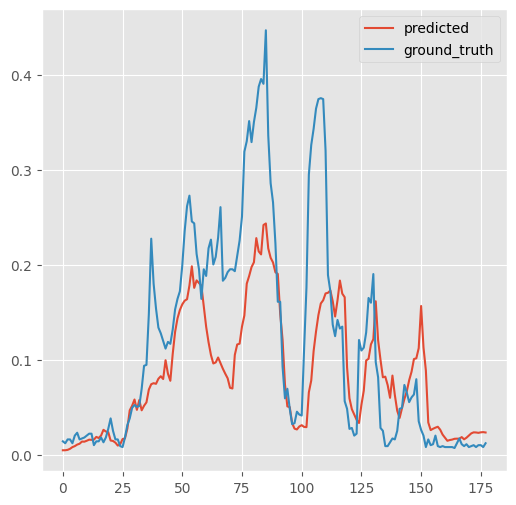

In [29]:
with torch.no_grad():
    h = None
    predicted, h = model(X_test.reshape(-1, window_size, 9).to(device))
    h = [hi.detach() for hi in h]
plt.figure(figsize=(6, 6))
plt.plot(predicted.detach().cpu().numpy(), label='predicted')
plt.plot(y_test, label='ground_truth')
plt.legend()
plt.show()